https://github.com/TrashSure-Team/trashsure-ml-classification-model 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import os
import cv2

from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
IMG_SIZE = 128
BATCH_SIZE = 32

### Base Model Architecture

In [ ]:
# MobileNetV2 Base
def create_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                                   include_top=False, weights='imagenet')

# Fine-Tune the Model by adding Fully Connected Layers
    for layer in base_model.layers[:-10]:
        layer.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),  # Add Dropout for Regularization
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),  # Add Dropout for Regularization
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    return model

# Create the Model
model = create_model()
model.compile(optimizer='Adam',
              loss=tf.keras.losses.categorical_crossentropy, 
              metrics=[tf.keras.metrics.categorical_accuracy])

model.summary()

### Load Pre-Trained Model

In [54]:
model = tf.keras.models.load_model('TrashSure-model.h5')
# model = tf.keras.models.load_model('fine-tuned/fine_tuned_no_Window_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3

In [5]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0 # Standard normalization to [0, 1]
    # img_array = (img_array / 127.5) - 1.0  # Normalize to [-1, 1]
    return img_array

In [29]:
# img_path = '../sample_data/metal_coke.jpg'
# img_path = '../sample_data/plastic_bottle_partial.jpg'
# img_path = '../../trainingData/metal/image_20240922_040431_4.jpg'
img_path = '../../trainingData/metal/image_20240922_034123_3.jpg'
# img_path = '../../trainingData/plastic/image_20240922_023123_10.jpg'
# img_path = '../../trainingData/plastic/image_20240922_031110_3.jpg'
# img_path = '../trainingData/metalNoLid/image_20240923_024508_1.jpg'
# img_path = '../trainingData/plasticNoLid/image_20240923_023256_1.jpg'

In [25]:
processed_image = preprocess_image(img_path)

In [30]:
# Perform inference
predictions = model.predict(processed_image)

# Retrieve the predicted class
class_indices = {'Glass': 0, 'Medical': 1, 'Metal': 2, 'Paper': 3, 'Plastic': 4, 'Textiles': 5, 'e-Waste': 6}
predicted_class = max(class_indices, key=lambda x: class_indices[x] == np.argmax(predictions))

print(f"Predicted Class: {predicted_class}")

1/1 [==============================] - 0s 32ms/step
Predicted Class: Glass


Pre-Trained Model Evaluation

In [39]:
del model

model = tf.keras.models.load_model('fine-tuned/fine_tuned_combined_best_model.h5')

In [55]:
# Test set directory
data_directory = '../trainingData'
categories = ['testMetal', 'testPlastic']

In [56]:
# Define class indices as per the model's training setup
# class_indices = {'Metal':0 , 'Plastic':1} # Fine-Tuned
class_indices = {'Glass': 0, 'Medical': 1, 'Metal': 2, 'Paper': 3, 'Plastic': 4, 'Textiles': 5, 'e-Waste': 6}

In [57]:
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    directory=data_directory,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    classes=categories
)

Found 60 images belonging to 2 classes.


In [58]:
# Get the true class indices from the generator
true_labels = test_generator.classes  # True labels from the test generator (0 for metalNoLid, 1 for plasticNoLid)

# Map the test generator class indices to the model's class indices
mapped_true_labels = [class_indices['Metal'] if label == 0 else class_indices['Plastic'] for label in true_labels]

predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

2/2 [==============================] - 1s 105ms/step


In [59]:
# Identify unique classes in both true and predicted labels
unique_classes = np.unique(np.concatenate((mapped_true_labels, predicted_labels)))

# Adjust class names to match unique classes present in the results
adjusted_class_labels = [list(class_indices.keys())[list(class_indices.values()).index(cls)] for cls in unique_classes]

In [60]:
# Calculate overall accuracy
accuracy = accuracy_score(mapped_true_labels, predicted_labels)

# Generate confusion matrix including all possible classes
conf_matrix = confusion_matrix(mapped_true_labels, predicted_labels, labels=unique_classes)

# Generate a classification report for the predicted classes
class_report = classification_report(mapped_true_labels, predicted_labels, target_names=adjusted_class_labels)

c:\Users\User\anaconda3\envs\image-processing\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\image-processing\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\image-processing\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [61]:
# Display the results
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.8167
Confusion Matrix:
[[20 10  0]
 [ 0  0  0]
 [ 0  1 29]]
Classification Report:
              precision    recall  f1-score   support

       Metal       1.00      0.67      0.80        30
       Paper       0.00      0.00      0.00         0
     Plastic       1.00      0.97      0.98        30

    accuracy                           0.82        60
   macro avg       0.67      0.54      0.59        60
weighted avg       1.00      0.82      0.89        60



In [62]:
# Custom analysis for all classes
print("\nDetailed Prediction Analysis:")
for true_label, pred_label in zip(mapped_true_labels, predicted_labels):
    true_class = list(class_indices.keys())[list(class_indices.values()).index(true_label)]
    pred_class = list(class_indices.keys())[list(class_indices.values()).index(pred_label)]
    
    if true_label == pred_label:
        print(f"Correct: True {true_class}, Predicted {pred_class}")
    else:
        print(f"Incorrect: True {true_class}, Predicted {pred_class}")

# Count predictions for each class
class_predictions = {class_name: sum(predicted_labels == class_index) 
                     for class_name, class_index in class_indices.items()}

print("\nPredictions per class:")
for class_name, count in class_predictions.items():
    print(f"{class_name}: {count}")


Detailed Prediction Analysis:
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Incorrect: True Metal, Predicted Paper
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Predicted Metal
Correct: True Metal, Pre

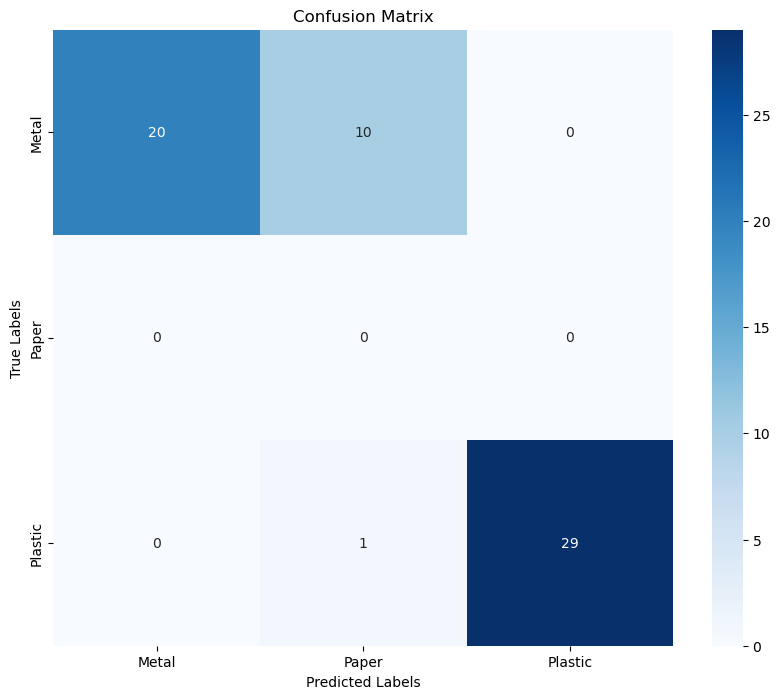

In [63]:
# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=adjusted_class_labels, yticklabels=adjusted_class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Fine Tuning

In [50]:
train_dir = "../../trainingData"
training_classes = ['metal', 'plastic'] 

# Create ImageDataGenerator for training with specific folders
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

# Define the train generator
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=training_classes,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    classes=training_classes,
    class_mode='categorical',
    subset='validation'
)

Found 648 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


### New Model Architecture

In [21]:
# # MobileNetV2 Base
# def create_model():
#     base_model = tf.keras.applications.MobileNetV2(
#         input_shape=(IMG_SIZE, IMG_SIZE, 3),
#         include_top=False,
#         weights='imagenet'
#     )

#     # Fine-Tune the Model by adding Fully Connected Layers
#     for layer in base_model.layers[:-10]:
#         layer.trainable = False

#     model = tf.keras.Sequential([
#         base_model,
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dropout(0.2),  # Add Dropout for Regularization
#         tf.keras.layers.Dense(512, activation='relu'),
#         tf.keras.layers.Dropout(0.2),  # Add Dropout for Regularization
#         tf.keras.layers.Dense(2, activation='softmax')
#     ])

#     return model

# # Create the Model
# model = create_model()
# model.compile(
#     optimizer=Adam(learning_rate=0.0001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model.summary()

### Transfer Learning

In [49]:
del model

model = tf.keras.models.load_model('TrashSure-model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3

In [51]:
# Remove the last layer (which is Dense(7))
model.pop()

# Add a new Dense layer with 2 units (for Metal and Plastic) and softmax activation
new_output = layers.Dense(2, activation='softmax')(model.layers[-1].output)

# Create a new model
model = tf.keras.Model(inputs=model.input, outputs=new_output)

# Freeze all layers except the new output layer
for layer in model.layers[:-1]:
    layer.trainable = False

# Check the updated structure of the model
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128_input   [(None, 128, 128, 3)]    0         
 (InputLayer)                                                    
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                           

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
# adjusts the learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# stops training when no further improvement is seen
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Saves the best model based on the validation loss
model_checkpoint = ModelCheckpoint('fine-tuned/fine_tuned_combined_model.h5', save_best_only=True, monitor='val_loss', mode='min')

In [57]:
data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [58]:
model.fit(
    train_generator,
    epochs=35,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)

Epoch 1/35
21/21 [==============================] - 5s 170ms/step - loss: 0.9131 - accuracy: 0.5340 - val_loss: 0.6214 - val_accuracy: 0.6806 - lr: 0.0010
Epoch 2/35
21/21 [==============================] - 3s 145ms/step - loss: 0.3943 - accuracy: 0.8164 - val_loss: 0.4031 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/35
21/21 [==============================] - 3s 152ms/step - loss: 0.3121 - accuracy: 0.8534 - val_loss: 0.3230 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 4/35
21/21 [==============================] - 3s 143ms/step - loss: 0.2728 - accuracy: 0.8827 - val_loss: 0.2795 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 5/35
21/21 [==============================] - 3s 145ms/step - loss: 0.2617 - accuracy: 0.8904 - val_loss: 0.2466 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 6/35
21/21 [==============================] - 3s 147ms/step - loss: 0.2453 - accuracy: 0.8889 - val_loss: 0.2367 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 7/35
21/21 [==============================] - 3s 142ms/step - lo

### Testing

In [59]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(128, 128))  # Replace with IMG_SIZE if different
    img_array = img_to_array(img)  # Convert the image to an array
    img_array = img_array.astype(np.float32)  # Ensure it's in float32 format
    img_array = (img_array / 127.5) - 1.0  # Normalize to [-1, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

In [60]:
def test_model(image_path, model):
    # Preprocess the image
    input_data = preprocess_image(image_path)
    
    # Run the inference
    prediction = model.predict(input_data)
    
    # Map the predicted class to the respective label
    class_labels = {0: 'Metal', 1: 'Plastic'}
    predicted_class = np.argmax(prediction)
    confidence_score = np.max(prediction)

    # Display the results
    print(f"Predicted Class: {class_labels[predicted_class]}")
    print(f"Confidence Score: {confidence_score:.2f}")


In [61]:
# img_path = '../sample_data/metal_coke.jpg'
# img_path = '../sample_data/plastic_bottle_partial.jpg'
# img_path = '../../trainingData/metal/image_20240922_040431_4.jpg'
# img_path = '../../trainingData/metal/image_20240922_034123_3.jpg'
# img_path = '../../trainingData/plastic/image_20240922_023123_10.jpg'
# img_path = '../../trainingData/plastic/image_20240922_031110_3.jpg'
# img_path = '../trainingData/metalNoLid/image_20240923_024508_1.jpg'
# img_path = '../trainingData/plasticNoLid/image_20240923_023256_1.jpg'

test_model(img_path, model)

1/1 [==============================] - 0s 476ms/step
Predicted Class: Metal
Confidence Score: 0.81


### Save weights and convert to tflite model

In [82]:
# model.save('fine-tuned/fine_tuned_no_Window_model.h5')

In [64]:
model = tf.keras.models.load_model('fine-tuned/fine_tuned_combined_model.h5')

# Convert the model to the TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('fine-tuned/fine_tuned_combined_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted and saved as model.tflite")

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpiy5jr2te\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpiy5jr2te\assets


Model converted and saved as model.tflite


### Test tflite model

In [44]:
interpreter = tf.lite.Interpreter(model_path="fine-tuned/fine_tuned_combined_model.tflite")
interpreter.allocate_tensors()

In [45]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [68]:
# print("Input Details:", input_details)
# print("Output Details:", output_details)

# # Get a list of all tensor details (including intermediate layers)
# all_tensor_details = interpreter.get_tensor_details()

# # Print information about each tensor in the model
# for layer in all_tensor_details:
#     print(f"Layer Name: {layer['name']}")
#     print(f"  Index: {layer['index']}")
#     print(f"  Shape: {layer['shape']}")
#     print(f"  Data Type: {layer['dtype']}")
#     print()

In [46]:
def preprocess_image(image_path):
    # Load the image using OpenCV
    img = cv2.imread(image_path)
    
    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize the image to the required dimensions
    img_resized = cv2.resize(img_rgb, (128, 128))
    
    # Normalize the image to the range [0, 1] or [-1, 1] depending on what the model expects
    img_normalized = img_resized.astype(np.float32) / 255.0  # Standard normalization [0, 1]
    # img_normalized = (img_resized.astype(np.float32) / 127.5) - 1.0 
    
    # Add a batch dimension
    img_batch = np.expand_dims(img_normalized, axis=0)
    return img_batch

In [59]:
# def preprocess_image(image_path):
#     img = load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
#     img_array = img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array /= 255.0 # Standard normalization to [0, 1]
#     # img_array = (img_array / 127.5) - 1.0  # Normalize to [-1, 1]
#     return img_array

In [28]:
# img_path = '../sample_data/metal_coke.jpg'
# img_path = '../sample_data/plastic_bottle_partial.jpg'
# img_path = '../../trainingData/metal/image_20240922_040431_4.jpg'
# img_path = '../../trainingData/metal/image_20240922_034123_3.jpg'
# img_path = '../../trainingData/plastic/image_20240922_023123_10.jpg'
# img_path = '../../trainingData/plastic/image_20240922_031110_3.jpg'
# img_path = '../trainingData/metalNoLid/image_20240923_024508_1.jpg'
img_path = '../trainingData/plasticNoLid/image_20240923_023256_1.jpg'

In [47]:
# Preprocess the image
input_data = preprocess_image(img_path)

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], input_data)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)
confidence_score = np.max(output_data)

class_labels = {0: 'Metal', 1: 'Plastic'}

print(f"Predicted Class: {class_labels[predicted_class]}, Confidence Score: {confidence_score:.2f}")

Predicted Class: Plastic, Confidence Score: 1.00


### Evaluation Metrics - TFLite Model

In [48]:
eval_dir = "../trainingData"
categories = ['testMetal', 'testPlastic']

In [49]:
# Load image paths and true labels
image_paths = []
true_labels = []
for label, category in enumerate(categories):
    category_path = os.path.join(eval_dir, category)
    for img_name in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, img_name))
        true_labels.append(label)

In [50]:
# Function to run inference on TFLite model
def run_inference_tflite(image_path):
    input_data = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_class = np.argmax(output_data)
    return predicted_class

In [51]:
predicted_labels = [run_inference_tflite(img_path) for img_path in image_paths]

In [52]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(true_labels, predicted_labels)
class_report = classification_report(true_labels, predicted_labels, target_names=categories)

# Display confusion matrix and classification report
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Accuracy: 0.9833

Confusion Matrix:
[[30  0]
 [ 1 29]]

Classification Report:
              precision    recall  f1-score   support

   testMetal       0.97      1.00      0.98        30
 testPlastic       1.00      0.97      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



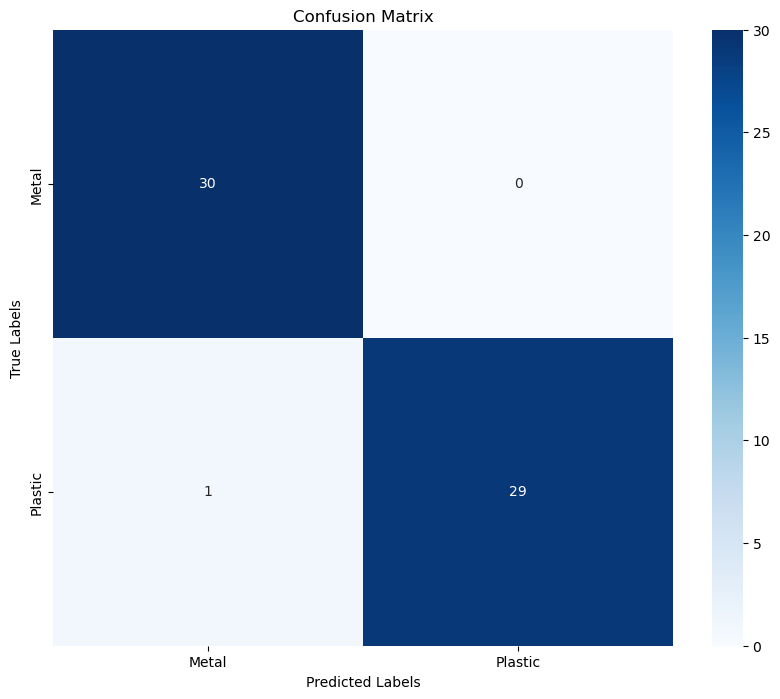

In [53]:
class_labels = ['Metal', 'Plastic']

# Visualize the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()